# Training a parametrized quantum circuit with Natural gradients

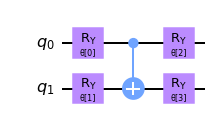

In [7]:
import numpy as np

# import RealAmplitudes from qiskit library
from qiskit.circuit.library import RealAmplitudes

# create the parametrized circuit
qnn = RealAmplitudes(num_qubits = 2, reps = 1,entanglement = 'linear').decompose()

qnn.draw()

* After choosing our circuit, we can define the hamiltonian that we want to apply to the system

In [8]:
from qiskit.opflow import Z, StateFn, PauliExpectation

# define the operator
operator = Z ^ Z

# then we get the expectation value
expentation_value = StateFn(operator, is_measurement = True) @ StateFn(qnn)
pauli_basis = PauliExpectation().convert(expentation_value)

* Then we can create a quantum instance for simulating the system and define a function that will evaluate the expectation value

In [9]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler 

simulator = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend = simulator, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)

sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x) :
    value_dict = dict(zip(qnn.parameters, x))
    result = sampler.convert(pauli_basis, params = value_dict).eval()
    return np.real(result)

* Now we can evaluate the natural descent, we can use NaturalGradient from qiskit library

In [10]:
from qiskit.opflow import NaturalGradient

natural_gradient = NaturalGradient().convert(expentation_value)
natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)

sampler = CircuitSampler(quantum_instance, caching = "all")

def evaluate_natural_gradient(point) :
    value_dict = dict(zip(qnn.parameters, point))
    result = sampler.convert(natural_gradient, params = value_dict).eval()
    return np.real(result)

# call the evaluation for the fitst time starting from initial point
starting_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

evaluate_natural_gradient(starting_point)

array([ 0.90157504,  5.2467371 , -4.07654481, -7.33108664])

* We can compute the losses and see the asymptotic behaiviour

In [11]:
# import gradient descent
from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA

losses = []

""" def loss_append(nfecs, x, fx, stepsize) :
    losses.append(fx);

# initialize grad descent
grad_descent = GradientDescent(maxiter = 300, learning_rate = 0.01, callback = loss_append)

# start optimization
grad_descent.optimize(starting_point.size, objective_function = evaluate_expectation, gradient_function = evaluate_natural_gradient, initial_point = starting_point) """

spsa_losses = []

def spsa_callback(nfev, x, fx, stepsize, accepted) :
    spsa_losses.append(fx)

spsa = SPSA(maxiter = 300, learning_rate = 0.01, perturbation = 0.01, callback = spsa_callback)

spsa.optimize(starting_point.size, evaluate_expectation, initial_point = starting_point)

# fo the same procedure with other algorithm, QNSPSA
qnspsa_losses = []

def qnspsa_callback(nfev, x, fx, stepsize, accepted) :
    qnspsa_losses.append(fx)

fidelity = QNSPSA.get_fidelity(qnn, quantum_instance, expectation = PauliExpectation())

qnspsa = QNSPSA(fidelity, maxiter = 300, learning_rate = 0.01, perturbation = 0.01, callback = qnspsa_callback)

qnspsa.optimize(starting_point.size, evaluate_expectation, initial_point = starting_point)

(array([-1.48131104,  0.38167266,  1.4456586 ,  1.68172804]),
 -0.9997558593750002,
 2101)

* Finally plot the losses from the various gradient methods used

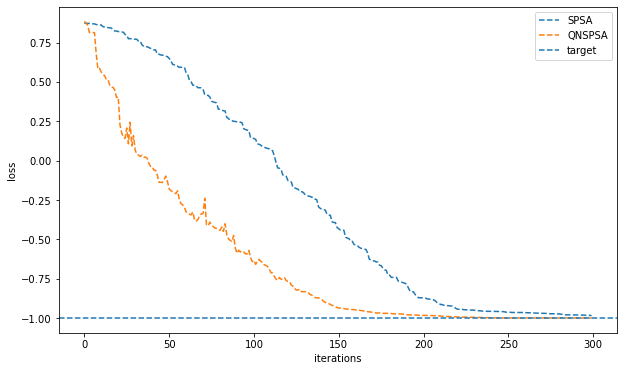

In [12]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10, 6))
plt.plot(spsa_losses, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_losses, 'C1', ls='--', label='QNSPSA')
plt.axhline(-1, ls = '--', c = 'C0', label = 'target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()